
# Zeitreihenvorhersage mit RNNs in Keras

RNNs zur Vorhersage von Zeitreihendaten mittels Keras.
Die Daten sind Zufallsdaten

In [1]:
# setup
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

# make a sample multivariable time series
# generate a random walk
def random_walk(steps, scale = 1):
    w = np.zeros(steps)
    for x in range(1,steps):
        w[x] = w[x-1] + scale * np.random.normal()
    return(w)
        
time_steps = 5000

# create data x,y,z
data = pd.DataFrame({'x' : range(time_steps), 'y' : np.arange(time_steps) ** (1/2) + random_walk(time_steps) })
data = data.assign(z = np.log(data.x+1) + 0.3 * data.y)

# convert to numpy array
data_mat = np.array(data)


2023-04-19 10:55:09.606300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 10:55:10.777816: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Die Daten sehen folgendermassen aus:

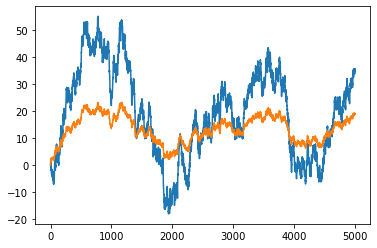

In [20]:
plt.plot(data['x'],data['y'])
plt.plot(data['x'],data['z'])

Folgend müssen die Daten etwas aufgeplittet werden in Test und Trainingsdaten:

In [26]:
# split into samples (sliding time windows)
samples = list()
target = list()
length = 50

# step over the 5,000 in jumps of length
for i in range(time_steps - length - 1):
  # grab from i to i + length
    sample = data_mat[i:i+length,:2]
    outcome = data_mat[i+length+1,2]
    target.append(outcome)
    samples.append(sample)

print(target[0])

2.186850451071902


In [27]:
# split out a test set
test_size = 1000
x_test_mat = np.dstack(samples[-test_size:])
x_test_3d_final = np.moveaxis(x_test_mat, [0, 1, 2], [1, 2, 0] )

# The RNN needs data with the format of [samples, time steps, features].
# Here, we have N samples, 50 time steps per sample, and 2 features
data_mat_stacked = np.dstack(samples[:-test_size])
data_mat_3d_final = np.moveaxis(data_mat_stacked, [0, 1, 2], [1, 2, 0] )

# and fix up the target
target_arr = np.array(target[:-test_size])

Das Model wird dann relativ einfach mit Keras und SimpleRNN gebildet:

Epoch 1/20
127/127 - 4s - loss: 1527.9319 - mse: 1527.9319 - val_loss: 12.7717 - val_mse: 12.7717 - 4s/epoch - 34ms/step
Epoch 2/20
127/127 - 2s - loss: 111.9130 - mse: 111.9130 - val_loss: 18.1854 - val_mse: 18.1854 - 2s/epoch - 14ms/step
Epoch 3/20
127/127 - 2s - loss: 99.8571 - mse: 99.8571 - val_loss: 16.9915 - val_mse: 16.9915 - 2s/epoch - 14ms/step
Epoch 4/20
127/127 - 2s - loss: 92.1027 - mse: 92.1027 - val_loss: 20.3935 - val_mse: 20.3935 - 2s/epoch - 13ms/step
Epoch 5/20
127/127 - 2s - loss: 90.0987 - mse: 90.0987 - val_loss: 12.8570 - val_mse: 12.8570 - 2s/epoch - 14ms/step
Epoch 6/20
127/127 - 2s - loss: 87.5933 - mse: 87.5933 - val_loss: 61.7855 - val_mse: 61.7855 - 2s/epoch - 15ms/step
Epoch 7/20
127/127 - 2s - loss: 37.6725 - mse: 37.6725 - val_loss: 21.7313 - val_mse: 21.7313 - 2s/epoch - 15ms/step
Epoch 8/20
127/127 - 2s - loss: 29.4052 - mse: 29.4052 - val_loss: 12.7782 - val_mse: 12.7782 - 2s/epoch - 14ms/step
Epoch 9/20
127/127 - 2s - loss: 24.2985 - mse: 24.2985 - v

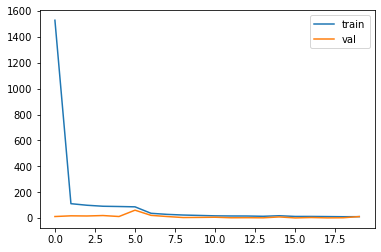

In [28]:
# now build the RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape = (data_mat_3d_final.shape[1], data_mat_3d_final.shape[2]), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
   
# compile the model    
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])

# and train the model
history = model.fit(data_mat_3d_final, target_arr, epochs=20, batch_size=25, verbose=2, validation_split = 0.20)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

Final kann man dann die Predictions und die Testdaten vergleichen:

32/32 [==============================] - 0s 7ms/step


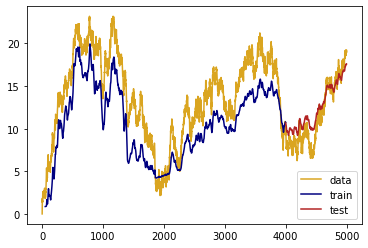

In [29]:
# get predictions
train_predictions = model.predict(data_mat_3d_final)
test_predictions = model.predict(x_test_3d_final)

# plot predictions vs actual
plt.plot(data['x'], data['z'], c = 'goldenrod', label = 'data')
plt.plot(data.iloc[(length+1):-test_size]['x'], train_predictions, c = 'navy', label = 'train')
plt.plot(data.iloc[-test_size:]['x'], test_predictions, c = 'firebrick', label = 'test')
plt.legend(loc='best')
plt.show()